In [1]:
import requests
from bs4 import BeautifulSoup

import pandas as pd
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

import json

# Assignment

**Task 1**: Obtain the 200 top-ranking universities in [www.topuniversities.com](https://www.topuniversities.com/university-rankings/world-university-rankings/2018 "Title") (ranking 2018). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/epfl-ecole-polytechnique-federale-de-lausanne "Title"). Store the resulting dataset in a pandas DataFrame

In [2]:
URL_top_universities = 'https://www.topuniversities.com/university-rankings/world-university-rankings/2018'

r_empty = requests.get(URL_top_universities)
r_empty = BeautifulSoup(r_empty.text, 'html.parser')

with open('foo_empty.html', 'w', encoding='utf-8') as file:
    file.write(r_empty.prettify())

In [3]:
r_top_per_uni = requests.get('https://www.topuniversities.com/universities/massachusetts-institute-technology-mit')
r_top_per_uni = BeautifulSoup(r_top_per_uni.text, 'html.parser')

with open('foo_per_uni.html', 'w', encoding='utf-8') as file:
    file.write(r_top_per_uni.prettify())

In [4]:
# 'foo_empty.html' can be opened in a web browser to see that we don't get all the desired data
# and so we will proceed differently, i.e. using a json format instead of the BeautifulSoup output.

r_topuni = requests.get('https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051_indicators.txt')
r_topuni = json.loads(r_topuni.text)

#print(r_topuni['data'][0])

In [5]:
def get_pers_numbers(url_per_uni):
    numbers = {}
    
    r_top_per_uni = requests.get(url_per_uni)
    r_top_per_uni = BeautifulSoup(r_top_per_uni.text, 'html.parser')
    
    all_numbers = r_top_per_uni.find_all('div', class_='rank tab-pane fees')[0]
    
    for hh in all_numbers.find_all('h4'):
        numbers[hh.text.split(' - ')[0]] = int(hh.text.split(' - ')[1].replace(',', ''))
        
    if all_numbers.find('label', string='International staff') is not None:
        numbers['International staff'] = int(all_numbers.find('label', string='International staff').find_next().text[1:].replace(',', ''))
    
    return numbers


def compute_ratios(list_uni):
    
    for kk in range(len(list_uni)):
        if ('Total faculty staff' in list_uni[kk].keys()) and ('Total students' in list_uni[kk].keys()):
            list_uni[kk]['Ratio between faculty members and students'] = list_uni[kk]['Total faculty staff'] / list_uni[kk]['Total students']
        
        if ('International students' in list_uni[kk].keys()) and ('Total students' in list_uni[kk].keys()):
            list_uni[kk]['Ratio of international students'] = list_uni[kk]['International students'] / list_uni[kk]['Total students']
            
    return list_uni


def get_topuni_data(url_basic, json_data):
    out = list(dict())

    for ll in range(min(200, len(json_data['data']))):
        name_html = json_data['data'][ll]['uni']
        idx_open = [i for i, a in enumerate(name_html) if a == '<']
        idx_close = [i for i, a in enumerate(name_html) if a == '>']
        
        name = name_html[idx_close[2]+1 : idx_open[3]]
        rank = json_data['data'][ll]['overall_rank']
        loc = json_data['data'][ll]['location']
        region = json_data['data'][ll]['region']
        
        url_to_add = name_html[idx_open[2]+1 : idx_close[2]][8:-1]
        
        numbers_per_uni = get_pers_numbers(url_basic + url_to_add)
                    
        out.append({**{'Name': name, 'Rank': rank, 'Country': loc, 'Region': region}, **numbers_per_uni})
        
    out = compute_ratios(out)
    print('Done!')
                    
    return out

In [6]:
data_200topuni = get_topuni_data('https://www.topuniversities.com', r_topuni)

Done!


In [7]:
data_200topuni = pd.DataFrame(data_200topuni)
data_200topuni.head()

,Country,International staff,International students,Name,Rank,Ratio between faculty members and students,Ratio of international students,Region,Total faculty staff,Total students
0,United States,1696.0,3732.0,Massachusetts Institute of Technology (MIT),1,0.269987,0.334859,North America,3009,11145.0
1,United States,2115.0,3665.0,Stanford University,2,0.270592,0.227146,North America,4366,16135.0
2,United States,1383.0,5495.0,Harvard University,3,0.199850,0.241783,North America,4542,22727.0
3,United States,407.0,667.0,California Institute of Technology (Caltech),4,0.450648,0.297901,North America,1009,2239.0
4,United Kingdom,2749.0,7049.0,University of Cambridge,5,0.291673,0.367078,Europe,5601,19203.0


The number of international students and faculty members is unknown for all Latin American universities.

In [8]:
#data_200topuni[data_200topuni['Region'] == 'Latin America']

In [9]:
per_region = data_200topuni.groupby(['Region'])['Ratio between faculty members and students', 
                                                'Ratio of international students'].mean()

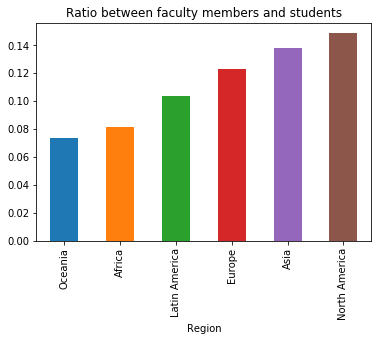

In [10]:
to_plot = 'Ratio between faculty members and students'
ax = (per_region[to_plot].sort_values()).plot.bar(title=to_plot)

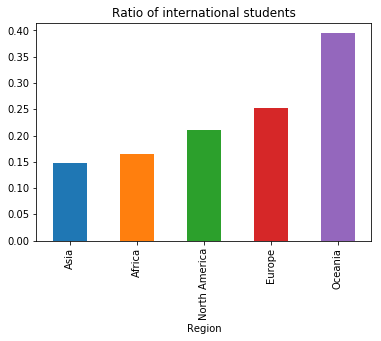

In [15]:
to_plot = 'Ratio of international students'
ax = (per_region[to_plot].dropna().sort_values()).plot.bar(title=to_plot)

In [12]:
per_country = data_200topuni.groupby(['Country'])['Ratio between faculty members and students', 
                                                'Ratio of international students'].mean()

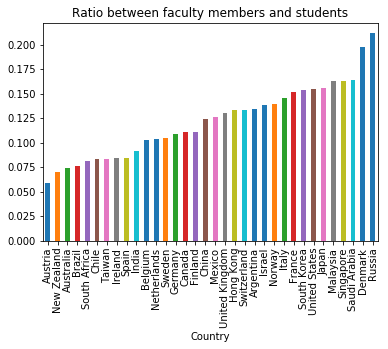

In [13]:
to_plot = 'Ratio between faculty members and students'
ax = (per_country[to_plot].sort_values()).plot.bar(title=to_plot)

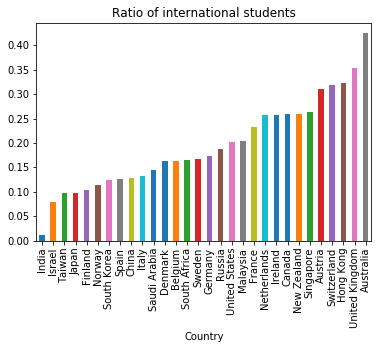

In [16]:
to_plot = 'Ratio of international students'
ax = (per_country[to_plot].dropna().sort_values()).plot.bar(title=to_plot)

**Task 2**: Obtain the 200 top-ranking universities in [www.timeshighereducation.com](https://www.timeshighereducation.com/world-university-rankings/2018/world-ranking#!/page/0/length/25/sort_by/rank/sort_order/asc/cols/stats "Title") (ranking 2018) and repeat the same analysis as above.

In [32]:
#URL_higher_education = 'https://www.timeshighereducation.com/world-university-rankings/2018/world-ranking#!/page/0/length/25/sort_by/rank/sort_order/asc/cols/stats'

r_highedu = requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')
r_highedu = json.loads(r_highedu.text)

In [35]:
r_highedu['data'][0]

{'rank_order': '10',
 'rank': '1',
 'name': 'University of Oxford',
 'scores_overall': '94.3',
 'scores_overall_rank': '10',
 'scores_teaching': '86.7',
 'scores_teaching_rank': '5',
 'scores_research': '99.5',
 'scores_research_rank': '1',
 'scores_citations': '99.1',
 'scores_citations_rank': '15',
 'scores_industry_income': '63.7',
 'scores_industry_income_rank': '169',
 'scores_international_outlook': '95.0',
 'scores_international_outlook_rank': '24',
 'record_type': 'master_account',
 'member_level': '0',
 'url': '/world-university-rankings/university-oxford',
 'nid': 468,
 'location': 'United Kingdom',
 'stats_number_students': '20,409',
 'stats_student_staff_ratio': '11.2',
 'stats_pc_intl_students': '38%',
 'stats_female_male_ratio': '46 : 54',
 'aliases': '牛津大学',
 'subjects_offered': 'Computer Science,Civil Engineering,Mathematics & Statistics,Languages, Literature & Linguistics,Physics & Astronomy,Biological Sciences,General Engineering,Electrical & Electronic Engineering,Ch